This notebook uses the covariance matrix emulator presented by Tom McClintock ([https://github.com/tmcclintock/covariance_emulator](https://github.com/tmcclintock/covariance_emulator))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import george
import covariance_emulator as ce
import time, sys

sys.path.insert(1, '/home/jadamo/CovA-NN-Emulator')
from CovNet import MatrixDataset, symmetric_log, symmetric_exp, try_gpu
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
PCA_dir = "/home/jadamo/CovA-NN-Emulator/Data/PCA-Set/"
training_dir = "/home/jadamo/CovA-NN-Emulator/Data/Training-Set/"
BOSS_dir = "/home/jadamo/CovA-NN-Emulator/Data/BOSS-DR12/"
CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
N_PCA = 100
N_test = int(52500*0.1)

In [3]:
# data and model vectors for chi squared calculations
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')

xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

First, load in the covariance matrices and parameters to use for the emulator

In [4]:
C_PCA = np.zeros((N_PCA, 100, 100))
params_PCA = np.zeros((N_PCA, 6))
for i in range(N_PCA):
    temp = np.load(PCA_dir+"CovA-"+f'{i:04d}'+".npz")
    params_PCA[i] = np.delete(temp["params"], 4)
    C_PCA[i] = torch.from_numpy(temp["C"])
    
    # if the matrix doesn't match the transpose close enough, manually flip over the diagonal
    try:
        np.testing.assert_allclose(C_PCA[i], C_PCA[i].T, err_msg="covariance must match transpose")
    except AssertionError:
        print("matrix", i, "has too high assymetry!")
        L = np.tril(C_PCA[i])
        U = np.tril(C_PCA[i], k=-1).T
        C_PCA[i] = L + U

matrix 14 has too high assymetry!
matrix 20 has too high assymetry!
matrix 52 has too high assymetry!
matrix 73 has too high assymetry!
matrix 74 has too high assymetry!
matrix 83 has too high assymetry!
matrix 91 has too high assymetry!


We'll use the same test set as the neural network emulator to allow consistent comparisons

In [5]:
t1 = time.time()
train_log = False; train_inverse = False
test_data = MatrixDataset(training_dir, N_test, int(52500*0.9), train_log, train_inverse)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 17.36 s


Now let's try an initial emulation of some of the parameter-sets in the test set

In [6]:
# Create an emulator
print(params_PCA.shape)
print(C_PCA.shape)
Emu = ce.CovEmu(params_PCA, C_PCA, NPC_D=20, NPC_L=20)

(100, 6)
(100, 100, 100)


In [7]:
# Loop thru the test set to calculate chi squared shifts
chisq_err = np.zeros(N_test)
for idx in range(N_test):
    C_test = test_data[idx][1].cpu().detach().numpy()
    params_test = test_data[idx][0].cpu()
    C_predict = Emu.predict(params_test)
    chisq_test = chi_squared(C_test, x)
    chisq_predict = chi_squared(C_predict, x)
    chisq_err[idx] = abs(chisq_predict - chisq_test)

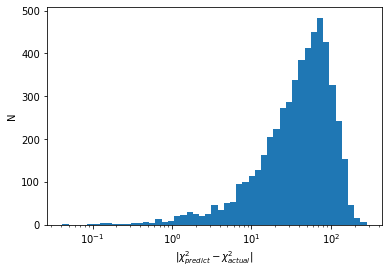

In [8]:
plt.hist(chisq_err, bins=np.logspace(np.log10(np.amin(chisq_err)), np.log10(np.amax(chisq_err)), 50))
#plt.hist(chisq_err, bins=50)
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

1284.1890533914543 1294.0289758273304


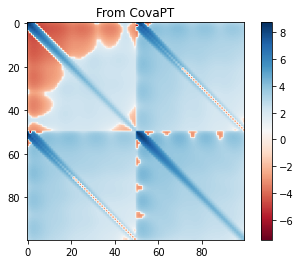

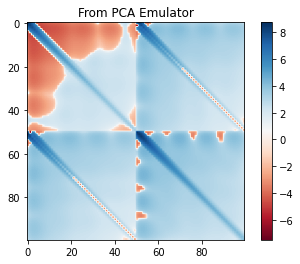

In [9]:
idx = np.random.randint(0, N_test)
C_test = test_data[idx][1]
params_test = test_data[idx][0].cpu()

C_predict = Emu.predict(params_test)
C_1 = symmetric_log(C_test).cpu().detach().numpy()
C_2 = symmetric_log(torch.from_numpy(C_predict).to(try_gpu()).float()).cpu().detach().numpy()

chisq_test = chi_squared(C_test.cpu().detach().numpy(), x)
chisq_predict = chi_squared(C_predict, x)
print(chisq_test, chisq_predict)
plt.figure()
plt.title("From CovaPT")
plt.imshow(C_1, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title("From PCA Emulator")
plt.imshow(C_2, cmap="RdBu")
cbar = plt.colorbar()